In [20]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [6]:
## Need to define a scaling function that ignores categorical values...?

In [7]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)  

Using TensorFlow backend.


In [35]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.469, Acc:0.8835
Prediction Accuracy
28/28 [==============================] - 0s 22us/step
Scores on data set: loss=0.762 accuracy=0.6786
Fold Correct: 19
Running worker: 1
Fold: 1 -> Loss:0.482, Acc:0.8797
Prediction Accuracy
28/28 [==============================] - 0s 17us/step
Scores on data set: loss=0.440 accuracy=0.7857
Fold Correct: 22
Running worker: 2
Fold: 2 -> Loss:0.492, Acc:0.8722
Prediction Accuracy
28/28 [==============================] - 0s 26us/step
Scores on data set: loss=0.444 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.474, Acc:0.8910
Prediction Accuracy
28/28 [==============================] - 0s 28us/step
Scores on data set: loss=0.309 accuracy=0.9286
Fold Correct: 26
Running worker: 4
Fold: 4 -> Loss:0.463, Acc:0.8759
Prediction Accuracy
27/27 [==============================] - 0s 29us/step
Scores on data set: loss=0.940 accuracy=0.7407
Fold Correct: 20
Running worker: 5
F

Confusion matrix, without normalization
[[0.7983871  0.2016129 ]
 [0.13513514 0.86486486]]


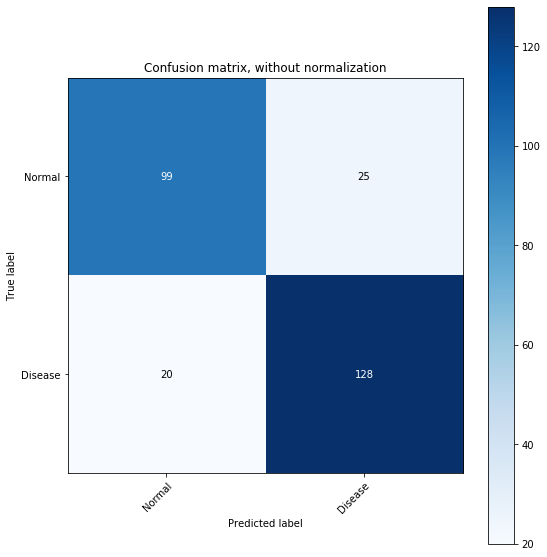

In [36]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

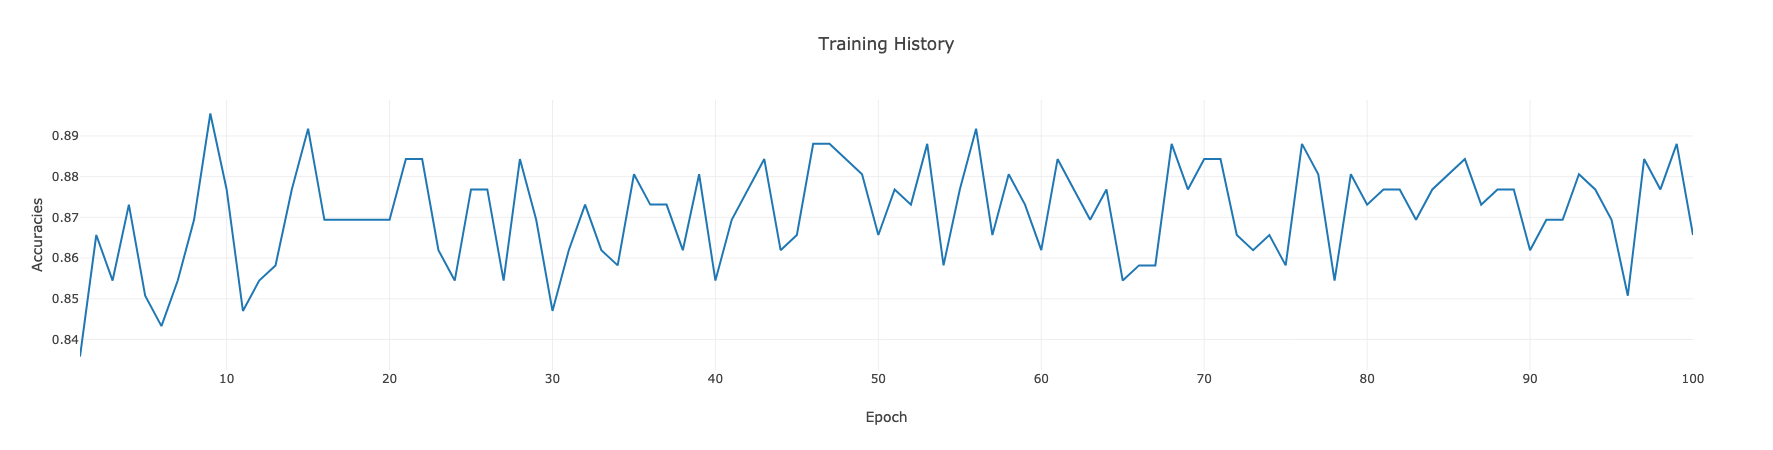

In [37]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [38]:
pipeline.reducer_pipeline = Pipeline([
                                ("umap", umap.UMAP(random_state=42,
                                                n_components = 10,
                                                n_neighbors=15,
                                                min_dist=0)),
                               ("scaler", MinMaxScaler())
                            ])

pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",4,0.0,0.115571,0.115571
"(13, 12)",4,0.0,0.115571,0.115571
"(13, 13)",4,0.0,0.115571,0.115571
"(14, 12)",4,0.0,0.115571,0.115571
"(14, 13)",4,0.0,0.115571,0.115571
"(14, 14)",4,0.0,0.115571,0.115571
"(15, 12)",4,0.0,0.115571,0.115571
"(15, 13)",4,0.0,0.115571,0.115571
"(15, 14)",4,0.0,0.115571,0.115571
"(15, 15)",4,0.0,0.115571,0.115571


In [39]:
pd.Series(pipeline.clusterer.labels_).value_counts()

2    35
0    34
3    33
1    26
dtype: int64

In [40]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [41]:
pd.Series(cluster_labels).value_counts()

2    9
3    6
dtype: int64

## Plotting Testing LRP

In [42]:


# correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
# split_class = correct_pred_labels == pipeline.target_class
# split_class_lrp = np.array(pipeline.lrp_results)[split_class]

lrp_data = pipeline.training_lrp
val_lrp = np.clip(pipeline.val_set_lrp, 0,None)

# s_lrp_data = MinMaxScaler().fit_transform(lrp_data)

In [43]:
# labels = correct_pred_labels[split_class]
len(lrp_data)

128

In [46]:
import umap
from matplotlib import pyplot as plt

embedding_pipeline_3d = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline_3d.fit(lrp_data)
embedding = embedding_pipeline_3d.transform(lrp_data)
val_embedding = embedding_pipeline_3d.transform(val_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='Rainbow',
        opacity=0.8,
#         showscale=True
    ),
    name="Training"
)

val_emb2d = go.Scatter3d(
    x=val_embedding[:,0],
    y=val_embedding[:,1],
    z=val_embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        colorscale='RdBu',
        opacity=0.8,
        showscale=True
    ),
    name="Validation"
)

layout2d = go.Layout(
    title= "3D LRP Embedding"
)

data=[emb3d, val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig)

In [48]:
relevance_embedding = embedding
relevance_embedding.shape

(128, 3)

In [49]:
from scipy.stats import entropy

nsamples = len(relevance_embedding)
nbins = 15

grid, edges = np.histogramdd(relevance_embedding, bins=nbins)
densities = (grid/nsamples).flatten()
entropy(densities)

2.9025657518496937

## Using UMAP as a preprocessing step to either
   ### - Reduce dimenions to improvce HDBSCAN performance
   ### - Contract clusters on a manifold inside the original dimension

In [60]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 13,
                    n_neighbors=15,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(lrp_data)

Pipeline(memory=None,
         steps=[('reducer',
                 UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
                      learning_rate=1.0, local_connectivity=1.0,
                      metric='euclidean', metric_kwds=None, min_dist=0,
                      n_components=13, n_epochs=None, n_neighbors=15,
                      negative_sample_rate=5, random_state=42,
                      repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
                      target_metric='categorical', target_metric_kwds=None,
                      target_n_neighbors=-1, target_weight=0.5,
                      transform_queue_size=4.0, transform_seed=42,
                      verbose=False)),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))],
         verbose=False)

In [61]:
import hdbscan
lrp_embedding = embedding_pipeline.transform(lrp_data)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=15,prediction_data=True)
clusterer.fit(lrp_embedding)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=15, min_samples=15, p=None,
        prediction_data=True)

In [62]:
pd.Series(clusterer.labels_).value_counts()

 2    31
 1    31
 0    28
-1    18
dtype: int64

In [29]:
embedding_pipeline_3d = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline_3d.fit(lrp_data)

embedding = embedding_pipeline_3d.transform(lrp_data)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        color=clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=clusterer.labels_
)

layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-val.html')

NameError: name 'clusterer' is not defined

### Validation LRP after UMAP Embedding

In [64]:
val_embedding = embedding_pipeline.transform(val_lrp)


cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_embedding)
pd.Series(cluster_labels).value_counts()

 1    24
-1     8
dtype: int64

In [65]:
val_3d_embedding = embedding_pipeline_3d.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8,
        showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title= "Val LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

## Plotting high dimensional clusters in lower dims

> Note that data points that cluster in higher dims do not *have* to cluster in lower dim UMAP projections

**Use the lower dims only for plotting and visual verification / data exploration**

In [39]:
data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

## Hyper Parameter search for HDBSCAN

In [40]:
from s_dbw import S_Dbw

ii32 = np.iinfo(np.int32)

plot=False        # FIXME: Assumes 2D data only
if plot:
    plt.close("Cluster Comparison") #1+len(cluster_sizes)
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(15,6*(+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")

    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

_metrics = []
cluster_sizes = range(10,17)
data = lrp_embedding
min_samp_start = 10

for i,size in enumerate(cluster_sizes):
    min_samples = range(min_samp_start,size+1)

    for j,min_s in enumerate(min_samples):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size, min_samples=min_s)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

        ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

    #     color_palette = sns.color_palette("bright", num_clusters)
    #     cluster_colors = [color_palette[x] if x >= 0
    #                     else (0, 0, 0)
    #                     for x in clusterer.labels_]
    #     cluster_member_colors = [sns.desaturate(x, p) for x, p in
    #                             zip(cluster_colors, clusterer.probabilities_)]

        # print(cluster_labels)
        noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind = [ii32.max]*4

        noise = list(cluster_labels).count(-1)/len(cluster_labels)
#         print(size,min_s)
#         print(pd.Series(clusterer.labels_).value_counts())
        if num_clusters > 1:
            halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')

            halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                        centr='mean', nearest_centr=True, metric='euclidean')


        _metrics.append([num_clusters,noise, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])

        if plot:
            axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
            axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
            axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    if plot:
        plt.tight_layout()
        plt.show()
        plt.savefig(self.FIGUREDIR+"cluster_perf_comp.png")
        plt.close("Cluster Comparison")

In [41]:
index  = [y for x in cluster_sizes for y in list(zip([x]*x,range(min_samp_start,x+1))) ]
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=index)
scores

,Clusters,Noise,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
"(10, 10)",4,0.009259,0.338060,0.308282,0.346928
"(11, 10)",4,0.009259,0.338060,0.308282,0.346928
"(11, 11)",4,0.009259,0.338060,0.308282,0.346928
"(12, 10)",4,0.009259,0.338060,0.308282,0.346928
"(12, 11)",4,0.009259,0.338060,0.308282,0.346928
"(12, 12)",4,0.009259,0.338060,0.308282,0.346928
"(13, 10)",4,0.009259,0.338060,0.308282,0.346928
"(13, 11)",4,0.009259,0.338060,0.308282,0.346928
"(13, 12)",4,0.009259,0.338060,0.308282,0.346928
"(13, 13)",4,0.009259,0.338060,0.308282,0.346928


In [42]:
scores.idxmin()

Clusters                  (14, 14)
Noise                     (15, 10)
Halkidi                   (10, 10)
Halkidi-Filtered Noise    (10, 10)
Halkidi-Bounded Noise     (10, 10)
dtype: object

In [43]:
msize, msamp = scores["Halkidi-Filtered Noise"].idxmin()

clusterer = hdbscan.HDBSCAN(min_cluster_size=msize, min_samples=msamp, prediction_data=True)
clusterer.fit(lrp_embedding)
pd.Series(clusterer.labels_).value_counts()

 1    35
 3    30
 0    28
 2    14
-1     1
dtype: int64

In [44]:
emb3d["marker"]["color"]=clusterer.labels_
emb3d["text"]=clusterer.labels_

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-val.html')

In [66]:
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_embedding)
pd.Series(cluster_labels).value_counts()

 1    24
-1     8
dtype: int64

In [67]:
val_emb3d["marker"]["color"]=cluster_labels
val_emb3d["text"]=cluster_labels

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

In [68]:
data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-val.html')

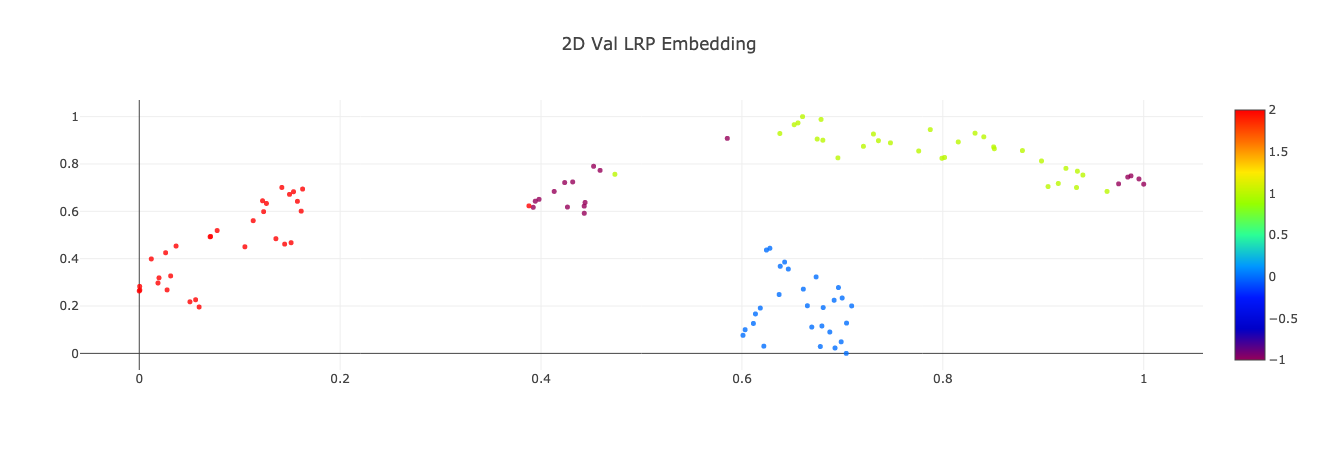

In [69]:
emb2d["marker"]["color"]=clusterer.labels_
emb2d["text"]=clusterer.labels_

data=[emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig)

## Plotting Validation LRP

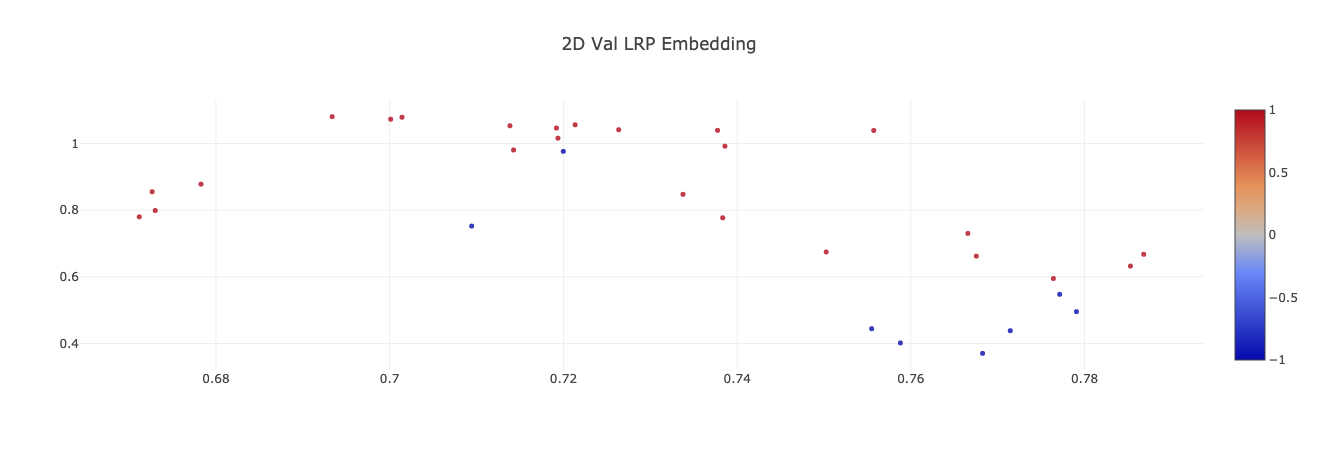

In [70]:
val_emb2d["marker"]["color"]=cluster_labels
val_emb2d["text"]=cluster_labels

data=[val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig, filename='lrp-val.html')

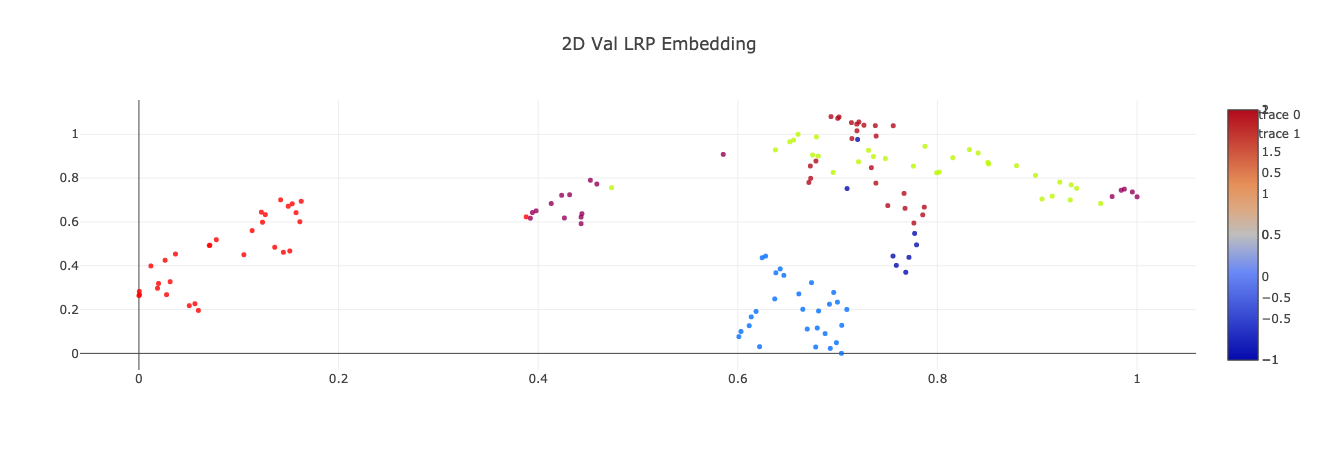

In [71]:
data=[emb2d, val_emb2d]

fig = go.Figure(data=data, layout=layout2d)
iplot(fig, filename='lrp-val.html')

# Performing Feature Reduction

In [95]:
cluster_label = 1

val_clustered = pd.DataFrame(val_lrp[(cluster_labels == cluster_label)])

In [96]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

In [97]:
val_clustered.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,24.0,24.000000,24.0,24.000000,24.000000,24.0,24.000000,24.0,24.000000,24.000000,24.0,24.000000,24.000000
mean,0.0,0.011525,0.0,1.686953,0.871487,0.0,0.000259,0.0,0.004567,0.009506,0.0,0.003446,0.061559
std,0.0,0.010886,0.0,0.559944,0.432693,0.0,0.000722,0.0,0.015500,0.011615,0.0,0.011678,0.031220
min,0.0,0.000000,0.0,0.607678,0.168666,-0.0,0.000000,0.0,0.000000,0.000000,-0.0,0.000000,0.019492
25%,0.0,0.000000,0.0,1.199269,0.568989,0.0,-0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.051231
50%,0.0,0.018704,0.0,1.769812,0.730425,-0.0,0.000000,0.0,0.000000,0.005670,0.0,0.000000,0.053711
75%,0.0,0.021517,0.0,2.163712,1.163418,0.0,0.000000,0.0,0.000000,0.014859,0.0,0.000000,0.068275
max,0.0,0.023776,0.0,2.667588,1.759837,-0.0,0.003237,0.0,0.057871,0.047645,-0.0,0.042380,0.181180


In [98]:
# thresh = min(val_clustered.describe().loc["75%"])

In [100]:
reduced_val = get_relevant_cols(val_clustered, thresh=0)
reduced_val

,1,3,4,9,12
0,0.021057,1.534213,0.673255,0.000000,0.052987
1,0.000000,1.941338,0.837727,0.000000,0.058966
2,0.000000,2.128900,0.596457,0.002655,0.053335
3,0.000000,0.876310,1.759837,0.000000,0.046261
4,0.022552,2.309746,0.573294,0.012088,0.052632
5,0.023776,1.730134,0.760166,0.008792,0.054088
6,0.000000,1.809491,0.700684,0.005440,0.056576
7,0.020854,2.276703,0.660575,0.030232,0.024500
8,0.020568,1.297243,0.849288,0.017065,0.057237
9,0.000000,1.386310,0.168666,0.018391,0.028414


## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [101]:
feature_idxs = reduced_val.columns
feature_idxs

Int64Index([1, 3, 4, 9, 12], dtype='int64')